# Practical demo of bootstrap process for linear polymer structure building and MD setup from scratch

In [1]:
# Warning suppression and logging
import warnings 
warnings.catch_warnings(record=True)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import logging
from polymerist.genutils.logutils.IOHandlers import LOG_FORMATTER

logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    force=True
)
LOGGER = logging.getLogger(__name__)
from IPython.display import clear_output

# Chemistry tools
from rdkit import Chem

from polymerist.rdutils import rdkdraw # configure molecule drawing
rdkdraw.set_rdkdraw_size(400, 3/2)
rdkdraw.disable_substruct_highlights()

# define output directory
from pathlib import Path

outdir = Path('polymer_demo_files')
outdir.mkdir(exist_ok=True)

2025-01-07 20:53:06.570 [INFO    :        __init__:line 22  ] - Enabling RDKit 2023.09.6 jupyter extensions
2025-01-07 20:53:07.301 [INFO    :           utils:line 149 ] - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-01-07 20:53:07.302 [INFO    :           utils:line 162 ] - NumExpr defaulting to 16 threads.


# 0) Predefining some monomer examples for you to play with

In [2]:
from dataclasses import dataclass, field
from enum import Enum, auto

class PortMethod(Enum):
    '''For specifying how ports should be added to a complete RDMol'''
    MAP_NUMBERS   = auto()
    BOND_CLEAVAGE = auto()
    REACTION      = auto() # not included here : provide an MDL rxn template

@dataclass
class MonomerExample:
    '''For encapsulating info about a base monomer unit'''
    molname : str
    smiles  : str
    bond_map_nums  : tuple[int, ...]
    isotope_map    : dict[int, int] = field(default_factory=dict)
    assign_port_by : PortMethod = field(default=PortMethod.BOND_CLEAVAGE)

In [3]:
# defining some concrete examples
monomer_examples = {
    'PVC' : MonomerExample(
        molname='polyvinylchloride',
        smiles='C=C-Cl',
        bond_map_nums=(1, 2),
        isotope_map={5 : 0, 6 : 0},
        assign_port_by=PortMethod.BOND_CLEAVAGE,
    ),
    'PE' : MonomerExample(
        molname = 'polyethylene',
        smiles = 'C=C',
        bond_map_nums=(1, 2),
        isotope_map = {3 : 0, 4 : 0},
        assign_port_by = PortMethod.BOND_CLEAVAGE
    ),
    'PAAm' : MonomerExample(
        molname = 'polyacrylamide',
        smiles = 'C=CC(=O)N',
        bond_map_nums=(1, 2),
        isotope_map = {7 : 0, 8 : 0},
        assign_port_by = PortMethod.BOND_CLEAVAGE
    ),
    'PS' : MonomerExample(
        molname = 'polystyrene',
        smiles = 'c1ccccc1C=C',
        bond_map_nums = (7, 8),
        isotope_map = {14 : 0, 16 : 0},
        assign_port_by = PortMethod.BOND_CLEAVAGE
    ),
    'Chitosan' : MonomerExample(
        molname = 'polyglucosamine',
        smiles = 'N[C@H]1C(O)OC(CO)[C@@H](O)[C@@H]1O',
        bond_map_nums=(7, 8),
        isotope_map = {17 : 0, 23 : 0},
        assign_port_by = PortMethod.MAP_NUMBERS
    )
}

# 1) Building monomer templates from basic SMILES

## Choose monomer HERE to define SMILES

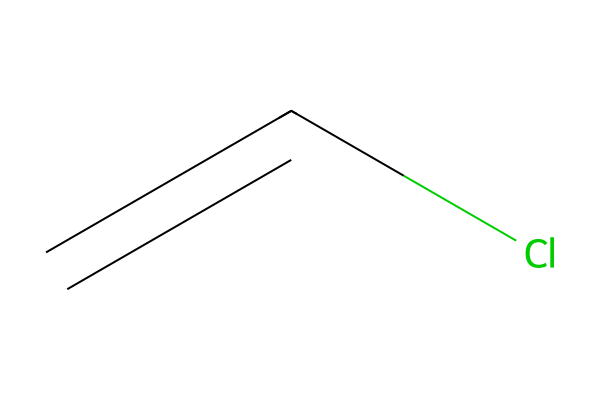

In [4]:
chosen_example = monomer_examples['PVC'] # feel at leisure to swap this out for another example
orig_smiles_mol = Chem.MolFromSmiles(chosen_example.smiles, sanitize=False)
display(orig_smiles_mol)

In [5]:
moldir = outdir / chosen_example.molname
moldir.mkdir(exist_ok=True, parents=True)

monodir = moldir / 'monomer_info'
monodir.mkdir(exist_ok=True)

## Expand SMILES to include full chemical info 
Namely, this includes explicit Hs, Kekulized aromatic rings, and atom map numbers

[C:1](=[C:2](-[Cl:3])-[H:6])(-[H:4])-[H:5]


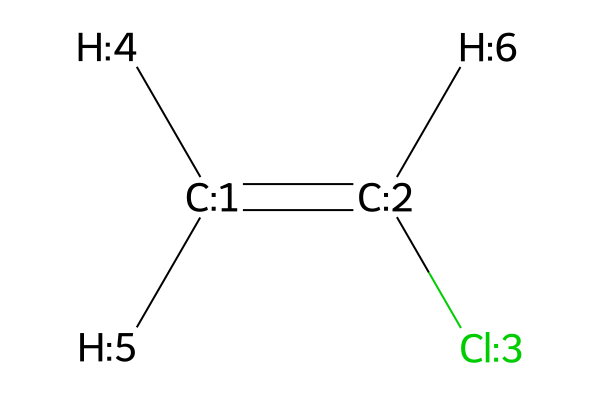

In [6]:
from polymerist.polymers.monomers import specification
from pathlib import Path


new_smiles = specification.expanded_SMILES(chosen_example.smiles)
FULL_SMILES_MOL = Chem.MolFromSmiles(new_smiles, sanitize=False)
print(new_smiles)
display(FULL_SMILES_MOL)

## Assigning linkers for inter-monomer bonds

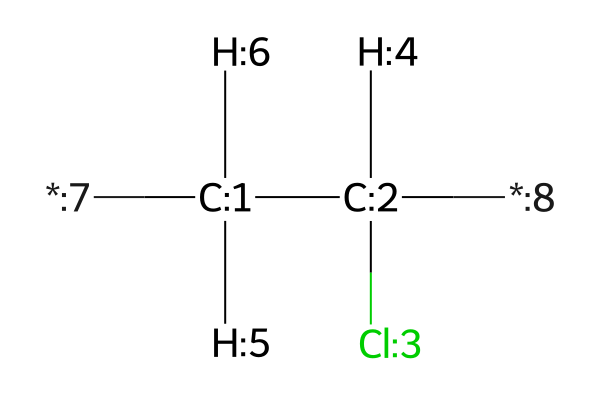

In [7]:
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils.bonding import portlib, dissolution


if portlib.get_num_ports(FULL_SMILES_MOL) == 0: # check for existence of ports to ensure idempotency
    if chosen_example.assign_port_by == PortMethod.MAP_NUMBERS:
        map_nums = chosen_example.isotope_map.keys()
        for (atom_id, map_num) in zip(molwise.atom_ids_by_map_nums(FULL_SMILES_MOL, *map_nums), map_nums):
            linker_atom = FULL_SMILES_MOL.GetAtomWithIdx(atom_id)
            linker_atom.SetIsotope(chosen_example.isotope_map[map_num])
            linker_atom.SetAtomicNum(0)

    elif chosen_example.assign_port_by == PortMethod.BOND_CLEAVAGE:
        rwmol = Chem.RWMol(FULL_SMILES_MOL)
        bond_atom_ids = molwise.atom_ids_by_map_nums(rwmol, *chosen_example.bond_map_nums)
        FULL_SMILES_MOL = dissolution.decrease_bond_order(rwmol, *bond_atom_ids)
        molwise.assign_ordered_atom_map_nums(FULL_SMILES_MOL, in_place=True)
        Chem.SanitizeMol(FULL_SMILES_MOL, sanitizeOps=specification.SANITIZE_AS_KEKULE) 

    elif chosen_example.assign_port_by == PortMethod.REACTION:
        raise NotImplemented
    else:
        raise TypeError(f'Must provide a valid port assignment method (cannot be of type {type(chosen_example.assign_port_by)})')

display(FULL_SMILES_MOL)

## Enumerating "cap" groups from linkers and generating spec-compliant SMARTS

In [8]:
from copy import deepcopy
from polymerist.genutils.iteration import subsets


smarts = {}
sat_ids = subsets(portlib.get_linker_ids(FULL_SMILES_MOL), exclude_full=True)
for i, linkers_to_saturate in enumerate(sat_ids):
    new_mono = deepcopy(FULL_SMILES_MOL)
    for linker_id in linkers_to_saturate:
        linker_atom = new_mono.GetAtomWithIdx(linker_id)
        linker_atom.SetAtomicNum(1)
    molwise.assign_ordered_atom_map_nums(new_mono, in_place=True) # renumber with added atoms to preserve order correspondence
    Chem.SanitizeMol(new_mono, sanitizeOps=specification.SANITIZE_AS_KEKULE) # sanitize for good measure, making sure NOT to re-add aromaticity

    key = chosen_example.molname if not i else f'{chosen_example.molname}_TERM{i}'
    smarts[key] = [specification.compliant_mol_SMARTS(Chem.MolToSmiles(new_mono))] # for some reason, MolToSmarts doesn't reflect hydrogen addition

2025-01-07 20:53:08.224 [WARNING :   specification:line 129 ] - Cleaned 8 SMARTS atom query aberrations introduced by RDKit
2025-01-07 20:53:08.227 [WARNING :   specification:line 129 ] - Cleaned 8 SMARTS atom query aberrations introduced by RDKit
2025-01-07 20:53:08.229 [WARNING :   specification:line 129 ] - Cleaned 8 SMARTS atom query aberrations introduced by RDKit


## Specify orientation of terminal monomers and create monomer representation object

2025-01-07 20:53:08.361 [INFO    :            repr:line 56  ] - Creating new residue category "polyvinylchloride", containing singular SMARTS ["[#6D4+0:1](-[#6D4+0:2](-[#17D1+0:3])(-[#1D1+0:4])-[*:8])(-[#1D1+0:5])(-[#1D1+0:6])-[*:7]"])
2025-01-07 20:53:08.363 [INFO    :            repr:line 56  ] - Creating new residue category "polyvinylchloride_TERM1", containing singular SMARTS ["[#6D4+0:1](-[#6D4+0:2](-[#17D1+0:3])(-[#1D1+0:4])-[*:8])(-[#1D1+0:5])(-[#1D1+0:6])-[#1D1+0:7]"])
2025-01-07 20:53:08.364 [INFO    :            repr:line 56  ] - Creating new residue category "polyvinylchloride_TERM2", containing singular SMARTS ["[#6D4+0:1](-[#6D4+0:2](-[#17D1+0:3])(-[#1D1+0:4])-[#1D1+0:8])(-[#1D1+0:5])(-[#1D1+0:6])-[*:7]"])


polyvinylchloride


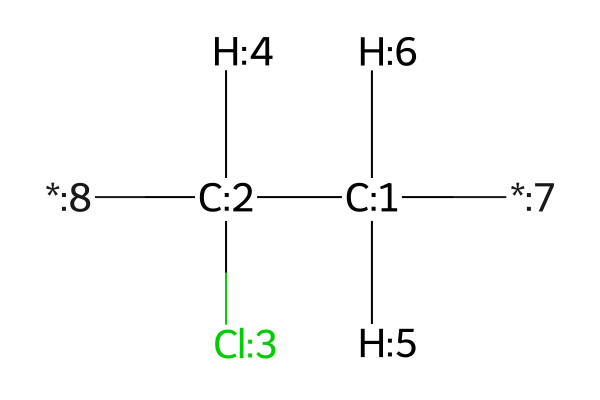

polyvinylchloride_TERM1


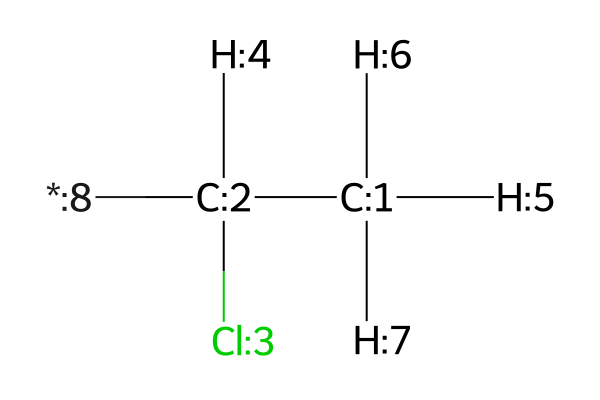

polyvinylchloride_TERM2


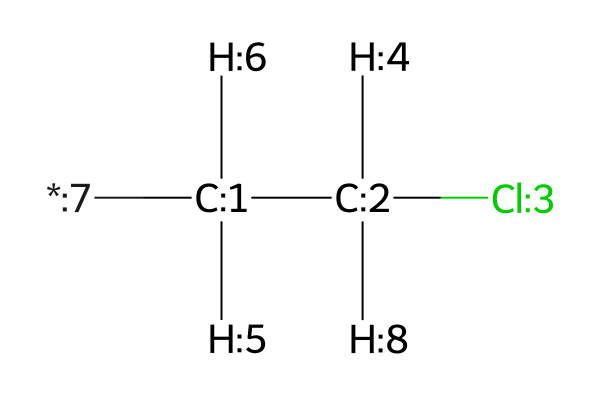

In [9]:
from polymerist.polymers.monomers import MonomerGroup
from polymerist.genutils.fileutils.pathutils import assemble_path

monogrp = MonomerGroup(
    monomers=smarts,
    term_orient={
        f'{chosen_example.molname}_TERM1' : 'head',
        f'{chosen_example.molname}_TERM2' : 'tail',
    }    
)

for (resname, rdmol) in monogrp.iter_rdmols():
    print(resname)
    display(rdmol)

mono_path = assemble_path(monodir, chosen_example.molname, extension='json')
monogrp.to_file(mono_path) # cache monomer SMARTS for future use

# 2) Generate coordinates and structure files with chemical info

In [10]:
pdbdir = moldir / 'pdb_structures'
pdbdir.mkdir(exist_ok=True)

sdfdir = moldir / 'sdf_structures'
sdfdir.mkdir(exist_ok=True)

## Grow chain of arbitrary DOP and generate PDB (only linear polymers currently supported)

In [11]:
from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb
from polymerist.polymers import estimation

n_monomers : int = 30

chain = build_linear_polymer(monogrp, n_monomers=n_monomers, sequence='A', energy_minimize=True)
pdb_path = assemble_path(pdbdir, chosen_example.molname, extension='pdb')
mbmol_to_openmm_pdb(pdb_path, chain)
chain.visualize(backend='nglview')

[20:53:09] WARNING: not removing hydrogen atom with dummy atom neighbors
2025-01-07 20:53:09.954 [WARNING :            repr:line 173 ] - No valid terminal monomer orientations defined, auto-assigned orientations "{'head': 'polyvinylchloride_TERM1', 'tail': 'polyvinylchloride_TERM2'}"; USER SHOULD VERIFY THIS YIELDS A CHEMICALLY-VALID POLYMER!
2025-01-07 20:53:09.955 [INFO    :      sequencing:line 72  ] - Sequence kernel "A" is already fully reduced; no changes made
2025-01-07 20:53:09.956 [INFO    :          linear:line 46  ] - Target chain length achievable with 28 whole 1-sequence repeat(s), namely with the sequence [polyvinylchloride_TERM1] + 28*[A] + [polyvinylchloride_TERM2]
2025-01-07 20:53:09.957 [INFO    :          linear:line 58  ] - Registering middle monomer polyvinylchloride (block identifier "A")
2025-01-07 20:53:09.991 [INFO    :          linear:line 65  ] - Registering terminal monomer polyvinylchloride_TERM1 (orientation "head")
2025-01-07 20:53:09.997 [INFO    :      

NGLWidget()

## Fill in missing PDB chemical info with our OpenFF substructure match tools
Subsequently, partition into distinct residues and save to info-rich SDF format to avoid duplication of effort

In [12]:
from openff.toolkit import Topology, Molecule
from polymerist.mdtools.openfftools import topology
from polymerist.mdtools.openfftools.partition import partition


# load PDB with substructure cover; if successful, refine into partition
offtop = Topology.from_pdb(pdb_path, _custom_substructures=monogrp.monomers)
was_partitioned = partition(offtop)
assert(was_partitioned)

# extract Molecule for Topology, set name and replace
offmol = topology.get_largest_offmol(offtop)
offmol.name = chosen_example.molname
offtop = offmol.to_topology()
display(offmol)

# serialize Topology to SDF to preserve fully-specified system
top_path = assemble_path(sdfdir, chosen_example.molname, extension='sdf')
topology.topology_to_sdf(top_path, offtop) 

NGLWidget()

# 3) Assignment of atomic partial charges
Here we will use a GNN charge model to acceleralte the assignment of charges for this demo \
However, if you prefer to use custom-generated library charges as per our paper, check out the accompanying [RCT notebook](rct_demo.ipynb) for more details

In [13]:
from polymerist.mdtools.openfftools.partialcharge.molchargers import EspalomaCharger


charger = EspalomaCharger()
espmol = charger.charge_molecule(offmol) # inherits name from base molecule

espmol_path = assemble_path(sdfdir, chosen_example.molname, postfix='charged', extension='sdf')
topology.topology_to_sdf(espmol_path, espmol.to_topology())

2025-01-07 20:53:22.412 [INFO    :     molchargers:line 45  ] - Assigning partial charges via the "Espaloma-AM1-BCC" method
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/espaloma_charge/openff_wrapper.py:112: IncorrectNumConformersWarning: Molecule 'Molecule with name 'polyvinylchloride' and SMILES '[H][C@]([C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])[C@@]([H])(C([H])([H])C([H])([H])C([H])([H])Cl)Cl)Cl)Cl)Cl)Cl)Cl)Cl)Cl